# **✅ Bagian 1: Import dan Setup**

In [1]:
import os
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns

# Transformers
from transformers import AutoTokenizer, AutoModel, Trainer, TrainingArguments

# Sklearn
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_recall_fscore_support,
    classification_report,
    confusion_matrix,
)

# ✅ Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# ✅ Tentukan path penyimpanan di Google Drive
my_drive_folder = "/content/drive/MyDrive/KlikBERT2/KlikBERT_SP/mBERT/7 Epoch/"

# ✅ Buat folder jika belum ada
os.makedirs(my_drive_folder, exist_ok=True)

# ✅ Ubah direktori kerja
os.chdir(my_drive_folder)

# ✅ Konfirmasi
print(f"✅ Current working directory set to: {os.getcwd()}")

# ✅ Cek CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Using device: {device}")


Mounted at /content/drive
✅ Current working directory set to: /content/drive/MyDrive/KlikBERT2/KlikBERT_SP/mBERT/7 Epoch
✅ Using device: cuda


#✅ Bagian 2: Load & Preprocess Dataset

In [2]:
# Contoh untuk load
df = pd.read_csv("https://raw.githubusercontent.com/gikirima/KlikBERT2/refs/heads/main/KlikBERT_dataset/labeled_data_balanced_2.csv")
df = df.drop_duplicates().dropna()
print(f"Data shape after cleaning: {df.shape}")

# Label Encoding
from sklearn.preprocessing import LabelEncoder
le_clickbait = LabelEncoder()
le_kategori = LabelEncoder()

df["clickbait_label_encoded"] = le_clickbait.fit_transform(df["clickbait_label"])
df["kategori_label_encoded"] = le_kategori.fit_transform(df["kategori_berita"])

print("Clickbait labels:", le_clickbait.classes_)
print("Kategori labels:", le_kategori.classes_)


Data shape after cleaning: (23757, 4)
Clickbait labels: ['exaggeration' 'misleading' 'non clickbait' 'teasing']
Kategori labels: ['bisnis' 'entertainment' 'kesehatan' 'kriminal' 'lifestyle' 'lingkungan'
 'politik' 'sport' 'teknologi']


# ✅ Bagian 3: Split Train/Val/Test

In [3]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(
    df, test_size=0.2, stratify=df["clickbait_label_encoded"], random_state=42
)
train_df, val_df = train_test_split(
    train_df, test_size=0.2, stratify=train_df["clickbait_label_encoded"], random_state=42
)

print(f"Train: {train_df.shape}, Val: {val_df.shape}, Test: {test_df.shape}")


Train: (15204, 6), Val: (3801, 6), Test: (4752, 6)


# ✅ Bagian 4: Tokenization

In [4]:
model_name = "google-bert/bert-base-multilingual-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
max_len = 256

def tokenize_batch(df):
    return tokenizer(
        df["judul"].tolist(),
        df["isi"].tolist(),
        truncation=True,
        padding=True,
        max_length=max_len
    )

train_enc = tokenize_batch(train_df)
val_enc = tokenize_batch(val_df)
test_enc = tokenize_batch(test_df)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

# **✅ Bagian 5: Dataset Class**

In [5]:
class MultiTaskDataset(Dataset):
    def __init__(self, encodings, clickbait_labels, kategori_labels):
        self.encodings = encodings
        self.clickbait_labels = clickbait_labels
        self.kategori_labels = kategori_labels

    def __len__(self):
        return len(self.clickbait_labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["clickbait_labels"] = torch.tensor(self.clickbait_labels[idx], dtype=torch.long)
        item["kategori_labels"] = torch.tensor(self.kategori_labels[idx], dtype=torch.long)
        return item

train_dataset = MultiTaskDataset(
    train_enc,
    train_df["clickbait_label_encoded"].tolist(),
    train_df["kategori_label_encoded"].tolist()
)
val_dataset = MultiTaskDataset(
    val_enc,
    val_df["clickbait_label_encoded"].tolist(),
    val_df["kategori_label_encoded"].tolist()
)
test_dataset = MultiTaskDataset(
    test_enc,
    test_df["clickbait_label_encoded"].tolist(),
    test_df["kategori_label_encoded"].tolist()
)


# ✅ Bagian 6: Define Model

In [6]:
class IndoBERTMultiTask(nn.Module):
    def __init__(self, model_name, num_clickbait_labels, num_kategori_labels):
        super().__init__()
        # Dua encoder BERT terpisah (soft sharing)
        self.bert_clickbait = AutoModel.from_pretrained(model_name)
        self.bert_kategori = AutoModel.from_pretrained(model_name)

        self.dropout = nn.Dropout(0.3)

        hidden_size = self.bert_clickbait.config.hidden_size

        self.clickbait_head = nn.Linear(hidden_size, num_clickbait_labels)
        self.kategori_head = nn.Linear(hidden_size, num_kategori_labels)

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        token_type_ids=None,
        clickbait_labels=None,
        kategori_labels=None
    ):
        # Encoder untuk clickbait
        clickbait_output = self.bert_clickbait(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids
        )
        pooled_clickbait = clickbait_output.last_hidden_state[:, 0, :]
        pooled_clickbait = self.dropout(pooled_clickbait)
        clickbait_logits = self.clickbait_head(pooled_clickbait)

        # Encoder untuk kategori
        kategori_output = self.bert_kategori(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids
        )
        pooled_kategori = kategori_output.last_hidden_state[:, 0, :]
        pooled_kategori = self.dropout(pooled_kategori)
        kategori_logits = self.kategori_head(pooled_kategori)

        # Hitung loss jika ada label
        loss = None
        loss_clickbait = None
        loss_kategori = None
        if clickbait_labels is not None and kategori_labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss_clickbait = loss_fct(clickbait_logits, clickbait_labels)
            loss_kategori = loss_fct(kategori_logits, kategori_labels)
            loss = loss_clickbait + loss_kategori

        return {
            "loss": loss,
            "loss_clickbait": loss_clickbait,
            "loss_kategori": loss_kategori,
            "clickbait_logits": clickbait_logits,
            "kategori_logits": kategori_logits
        }

model = IndoBERTMultiTask(
    model_name,
    num_clickbait_labels=len(le_clickbait.classes_),
    num_kategori_labels=len(le_kategori.classes_)
).to(device)


model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

# ✅ Bagian 7: Trainer Setup

In [7]:
class MultiTaskTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels_clickbait = inputs.pop("clickbait_labels")
        labels_kategori = inputs.pop("kategori_labels")

        outputs = model(
            **inputs,
            clickbait_labels=labels_clickbait,
            kategori_labels=labels_kategori
        )

        loss = outputs["loss"]
        loss_clickbait = outputs["loss_clickbait"].detach().cpu().item()
        loss_kategori = outputs["loss_kategori"].detach().cpu().item()
        loss_total = loss.detach().cpu().item()

        # ✅ Log ke Trainer logger
        self.log({
            "loss_total": loss_total,
            "loss_clickbait": loss_clickbait,
            "loss_kategori": loss_kategori
        })

        return (loss, outputs) if return_outputs else loss

training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=7,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    eval_strategy="steps",
    eval_steps=50,
    save_steps=200,
    save_total_limit=1,
    logging_dir="./logs",
    logging_strategy="steps",
    logging_steps=10,
    learning_rate=2e-5,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    report_to="tensorboard"  # ✅ Aktifkan logging ke TensorBoard
)

trainer = MultiTaskTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

In [8]:
# menyimpan hyperparameter training
with open("training_args.json", "w") as f:
    f.write(training_args.to_json_string())

# ✅ Bagian 8: Train

In [9]:
trainer.train()

Step,Training Loss,Validation Loss
50,1.170400,1.144137
100,0.954200,0.891050
150,0.929700,0.895826
200,0.753300,0.784286
250,0.665400,0.723784
300,0.520200,0.727281
350,0.585500,0.656924
400,0.518100,0.671518
450,0.567000,0.614298
500,0.344400,0.694902


TrainOutput(global_step=1666, training_loss=0.3680165096992204, metrics={'train_runtime': 2672.3879, 'train_samples_per_second': 39.825, 'train_steps_per_second': 0.623, 'total_flos': 0.0, 'train_loss': 0.3680165096992204, 'epoch': 7.0})

# **data log training tersimpan pada folder ./log**
jika ingin menampilkan grafik, run kode di bawah dalam notebook (melalui tensorboard).

direkomendasikan membuat grafik sendiri untuk paper


%load_ext tensorboard

%tensorboard --logdir ./logs

In [10]:
# Export Training Logs
import pandas as pd

# Ambil semua log
logs = trainer.state.log_history

# Convert ke DataFrame
df_logs = pd.DataFrame(logs)

# Simpan ke CSV
df_logs.to_csv("training_logs.csv", index=False)

print("✅ Log history disimpan ke training_logs.csv")

✅ Log history disimpan ke training_logs.csv


# ✅ Bagian 9: Evaluation

In [11]:
def get_predictions(trainer, dataset):
    loader = DataLoader(dataset, batch_size=8)
    all_clickbait = []
    all_kategori = []
    model.eval()
    with torch.no_grad():
        for batch in loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            token_type_ids = batch["token_type_ids"].to(device)

            outputs = model(input_ids, attention_mask, token_type_ids)
            pred_clickbait = outputs["clickbait_logits"].argmax(dim=1).cpu().tolist()
            pred_kategori = outputs["kategori_logits"].argmax(dim=1).cpu().tolist()

            all_clickbait.extend(pred_clickbait)
            all_kategori.extend(pred_kategori)

    return all_clickbait, all_kategori

pred_clickbait, pred_kategori = get_predictions(trainer, test_dataset)
true_clickbait = test_df["clickbait_label_encoded"].tolist()
true_kategori = test_df["kategori_label_encoded"].tolist()

# Joint Accuracy
joint_correct = [
    (a == b) and (c == d)
    for a, b, c, d in zip(true_clickbait, pred_clickbait, true_kategori, pred_kategori)
]
joint_acc = np.mean(joint_correct)
print(f"✅ Joint Accuracy: {joint_acc:.4f}")


✅ Joint Accuracy: 0.7624


# ✅ Bagian 10: Metrics & Report

In [12]:
def evaluate_task(true, pred, label_names, task_name):
    acc = accuracy_score(true, pred)
    print(f"\n✅ {task_name} Accuracy: {acc:.4f}")

    for avg in ['macro', 'micro', 'weighted']:
        f1 = f1_score(true, pred, average=avg)
        print(f" - {avg.capitalize()} F1: {f1:.4f}")

    # Per-class Precision, Recall, F1
    prec, rec, f1s, _ = precision_recall_fscore_support(true, pred)
    for i, label in enumerate(label_names):
        print(f"   {label}: Precision={prec[i]:.2f}, Recall={rec[i]:.2f}, F1={f1s[i]:.2f}")

    # Confusion Matrix
    cm = confusion_matrix(true, pred)
    plt.figure(figsize=(6,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_names, yticklabels=label_names)
    plt.title(f"{task_name} Confusion Matrix")
    plt.savefig(f"{task_name.lower().replace(' ','_')}_confusion_matrix.png")
    plt.close()

    # Classification Report
    report = classification_report(true, pred, target_names=label_names)
    print(report)
    with open(f"{task_name.lower().replace(' ','_')}_report.txt", "w") as f:
        f.write(report)

evaluate_task(true_clickbait, pred_clickbait, le_clickbait.classes_, "Clickbait")
evaluate_task(true_kategori, pred_kategori, le_kategori.classes_, "Kategori")



✅ Clickbait Accuracy: 0.8910
 - Macro F1: 0.8921
 - Micro F1: 0.8910
 - Weighted F1: 0.8915
   exaggeration: Precision=0.91, Recall=0.90, F1=0.90
   misleading: Precision=0.99, Recall=0.95, F1=0.97
   non clickbait: Precision=0.85, Recall=0.83, F1=0.84
   teasing: Precision=0.83, Recall=0.89, F1=0.86
               precision    recall  f1-score   support

 exaggeration       0.91      0.90      0.90      1156
   misleading       0.99      0.95      0.97      1179
non clickbait       0.85      0.83      0.84      1220
      teasing       0.83      0.89      0.86      1197

     accuracy                           0.89      4752
    macro avg       0.89      0.89      0.89      4752
 weighted avg       0.89      0.89      0.89      4752


✅ Kategori Accuracy: 0.8516
 - Macro F1: 0.8325
 - Micro F1: 0.8516
 - Weighted F1: 0.8505
   bisnis: Precision=0.67, Recall=0.93, F1=0.78
   entertainment: Precision=0.92, Recall=0.53, F1=0.67
   kesehatan: Precision=0.94, Recall=0.88, F1=0.91
   krimi

# ✅ Bagian 11: Bias Analysis

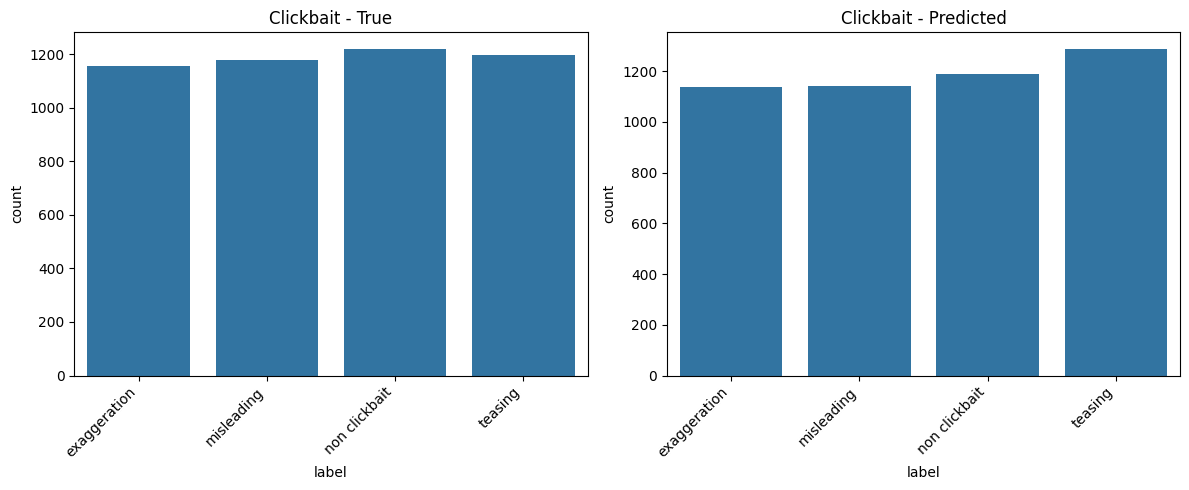

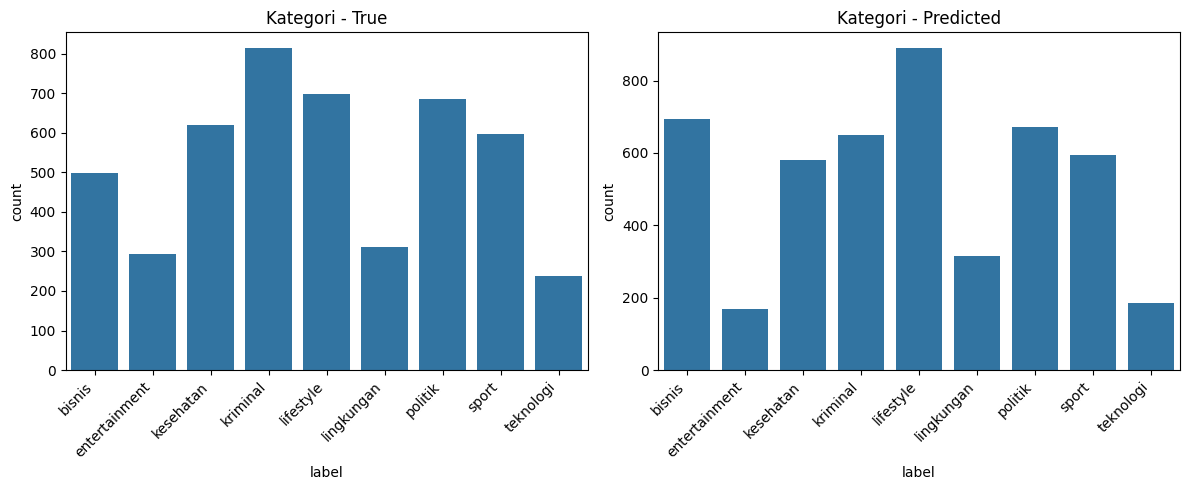

In [13]:
def plot_label_distribution(true, pred, labels, title):
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # Pastikan true/pred terkonversi ke np.array
    true = np.array(true)
    pred = np.array(pred)

    # Buat count DataFrame supaya seaborn tahu semua kategori
    true_counts = pd.DataFrame({'label': true})
    pred_counts = pd.DataFrame({'label': pred})

    sns.countplot(x='label', data=true_counts, order=range(len(labels)), ax=axs[0])
    axs[0].set_title(f"{title} - True")
    axs[0].set_xticks(range(len(labels)))
    axs[0].set_xticklabels(labels, rotation=45, ha='right')

    sns.countplot(x='label', data=pred_counts, order=range(len(labels)), ax=axs[1])
    axs[1].set_title(f"{title} - Predicted")
    axs[1].set_xticks(range(len(labels)))
    axs[1].set_xticklabels(labels, rotation=45, ha='right')

    plt.tight_layout()
    plt.savefig(f"{title.lower().replace(' ','_')}_distribution.png")
    plt.show()
    plt.close()


plot_label_distribution(true_clickbait, pred_clickbait, le_clickbait.classes_, "Clickbait")
plot_label_distribution(true_kategori, pred_kategori, le_kategori.classes_, "Kategori")

# ✅ Bagian 12: Simpan Model

In [14]:
save_dir = "./saved_model"
os.makedirs(save_dir, exist_ok=True)
torch.save(model.state_dict(), os.path.join(save_dir, "pytorch_model.bin"))
tokenizer.save_pretrained(save_dir)
print(f"\n✅ Model and tokenizer saved in {save_dir}")


✅ Model and tokenizer saved in ./saved_model


# ✅ Bagian 13: Simpan JSON

In [15]:
import json

config = {
  "architectures": ["IndoBERTMultiTask"],
  "model_type": "indobert-multitask",
  "num_clickbait_labels": 4,
  "num_kategori_labels": 9,
  "_name_or_path": "indobenchmark/indobert-base-p1"
}


with open(os.path.join(save_dir, "config.json"), "w") as f:
    json.dump(config, f, indent=2)